
# Caso práctico consumos


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, model_selection, metrics

# Leer Datos

In [2]:
data = pd.read_csv("Data/KAG_energydata_complete.csv")

In [3]:
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

# Resumen Datos

In [5]:
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [6]:
print('El Dataset tiene' , data.shape[0], 'filas')
print('El Dataset tiene'  , data.shape[1], 'columnas')

El Dataset tiene 19735 filas
El Dataset tiene 29 columnas


In [7]:
# Valores null
data.isnull().sum().sort_values(ascending = True)

date           0
Tdewpoint      0
Visibility     0
Windspeed      0
RH_out         0
Press_mm_hg    0
T_out          0
RH_9           0
T9             0
RH_8           0
T8             0
RH_7           0
T7             0
rv1            0
RH_6           0
RH_5           0
T5             0
RH_4           0
T4             0
RH_3           0
T3             0
RH_2           0
T2             0
RH_1           0
T1             0
lights         0
Appliances     0
T6             0
rv2            0
dtype: int64

### Limpieza de datos!

In [8]:
from sklearn.model_selection import train_test_split

# 75% de datos para entrenar, 25% para testear
train, test = train_test_split(data,test_size=0.25,random_state=40)

In [9]:
train.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,...,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000
mean,97.835281,3.809202,21.685153,40.271333,20.343487,40.432370,22.268005,39.252994,20.857724,39.041339,...,19.484679,41.567732,7.422035,755.561311,79.744066,4.057009,38.345054,3.768053,25.014452,25.014452
std,102.928289,7.940816,1.605537,3.983201,2.199037,4.081775,1.999986,3.263513,2.040012,4.355528,...,2.010610,4.167305,5.304241,7.398129,14.952250,2.449080,11.785900,4.189370,14.539819,14.539819
min,10.000000,0.000000,16.790000,27.233333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.366667,24.500000,0.000000,1.000000,-6.600000,0.006033,0.006033
25%,50.000000,0.000000,20.745000,37.363333,18.790000,37.900000,20.790000,36.900000,19.533333,35.530000,...,18.000000,38.500000,3.700000,750.983333,70.000000,2.000000,29.000000,0.933333,12.469764,12.469764
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.560000,20.666667,38.400000,...,19.390000,40.900000,6.933333,756.100000,83.833333,3.666667,40.000000,3.450000,24.936900,24.936900
75%,100.000000,0.000000,22.600000,43.090000,21.533333,43.290000,23.290000,41.790000,22.100000,42.193333,...,20.600000,44.363333,10.433333,760.966667,91.666667,5.500000,40.000000,6.566667,37.736202,37.736202
max,1080.000000,60.000000,26.260000,63.360000,29.856667,56.026667,29.200000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.033333,772.300000,100.000000,14.000000,66.000000,15.500000,49.993173,49.993173


###  De momento podemos ignorar la columna de la fecha y hora

In [10]:
# Nos quedan las siguentes features

col_temp = ["T1","T2","T3","T4","T5","T6","T7","T8","T9"]

col_hum = ["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]

col_weather = ["T_out", "Tdewpoint","RH_out","Press_mm_hg",
                "Windspeed","Visibility"] 
col_light = ["lights"]

col_randoms = ["rv1", "rv2"]

col_target = ["Appliances"]

In [11]:
# Podemos ver las features y la columna target
feature_vars = train[col_temp + col_hum + col_weather + col_light + col_randoms ]
target_vars = train[col_target]

In [12]:
feature_vars.describe()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,RH_1,...,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed,Visibility,lights,rv1,rv2
count,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,...,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000
mean,21.685153,20.343487,22.268005,20.857724,19.589105,7.923834,20.264300,22.028348,19.484679,40.271333,...,41.567732,7.422035,3.768053,79.744066,755.561311,4.057009,38.345054,3.809202,25.014452,25.014452
std,1.605537,2.199037,1.999986,2.040012,1.842916,6.083047,2.105079,1.951399,2.010610,3.983201,...,4.167305,5.304241,4.189370,14.952250,7.398129,2.449080,11.785900,7.940816,14.539819,14.539819
min,16.790000,16.100000,17.200000,15.100000,15.335000,-6.065000,15.390000,16.306667,14.890000,27.233333,...,29.166667,-5.000000,-6.600000,24.500000,729.366667,0.000000,1.000000,0.000000,0.006033,0.006033
25%,20.745000,18.790000,20.790000,19.533333,18.290000,3.663333,18.700000,20.790000,18.000000,37.363333,...,38.500000,3.700000,0.933333,70.000000,750.983333,2.000000,29.000000,0.000000,12.469764,12.469764
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.028571,22.111111,19.390000,39.656667,...,40.900000,6.933333,3.450000,83.833333,756.100000,3.666667,40.000000,0.000000,24.936900,24.936900
75%,22.600000,21.533333,23.290000,22.100000,20.633333,11.293333,21.600000,23.390000,20.600000,43.090000,...,44.363333,10.433333,6.566667,91.666667,760.966667,5.500000,40.000000,0.000000,37.736202,37.736202
max,26.260000,29.856667,29.200000,26.200000,25.745000,28.290000,25.963333,27.230000,24.500000,63.360000,...,53.326667,26.033333,15.500000,100.000000,772.300000,14.000000,66.000000,60.000000,49.993173,49.993173


In [13]:
# Vamos a mirar alguna distribución de los datos!
feature_vars.lights.value_counts()

0     11438
10     1649
20     1230
30      414
40       64
50        5
60        1
Name: lights, dtype: int64

In [14]:
target_vars.describe()

,Appliances
count,14801.000000
mean,97.835281
std,102.928289
min,10.000000
25%,50.000000
50%,60.000000
75%,100.000000
max,1080.000000


###  Primeras preguntas

1. Mirar rangos temperaturas

2. Mirar rangos humedades

3. Distribución consumo aparatos electricos

4. Nos puede dar información útil la columna del consumo de luces?

In [15]:
# Podems borrar la column de las luces
_ = feature_vars.drop(['lights'], axis=1 , inplace= True) ;

C:\Users\Ricard\anaconda3\envs\Smart_Energy\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
feature_vars.head(2)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,RH_1,...,RH_8,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed,Visibility,rv1,rv2
9544,22.6,19.5,21.50,22.89,19.166667,2.863333,21.0,22.89,19.89,34.70,...,38.5,37.26,2.233333,0.4,87.666667,764.200000,1.333333,61.000000,43.195492,43.195492
19366,23.7,21.0,25.39,23.60,19.890000,5.500000,23.0,24.20,22.60,40.29,...,43.4,44.59,6.266667,5.3,93.666667,757.233333,1.000000,25.333333,46.369677,46.369677


# Visualización 

In [17]:
# plotly
#import plotly.plotly as py
from chart_studio.plotly import iplot
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Time-series
visData = go.Scatter( x= data.date  ,  mode = "lines", y = data.Appliances )
layout = go.Layout(title = 'Appliance energy consumption measurement' , xaxis=dict(title='Date'), yaxis=dict(title='(Wh)'))
fig = go.Figure(data=[visData],layout=layout)

fig.show()

In [18]:
# Añadir columan indicando días entre setmana (0) y fines de semana (1) 

data['WEEKDAY'] = ((pd.to_datetime(data['date']).dt.dayofweek)// 5 == 1).astype(float)
# 5472 lecturas en fin de semana
data['WEEKDAY'].value_counts()

0.0    14263
1.0     5472
Name: WEEKDAY, dtype: int64

In [19]:
# Filas de lecturas entre semana
temp_weekday =  data[data['WEEKDAY'] == 0]
# Graficar
visData = go.Scatter( x= temp_weekday.date  ,  mode = "lines", y = temp_weekday.Appliances )
layout = go.Layout(title = 'Appliance energy consumption measurement on weekdays' , xaxis=dict(title='Date'), yaxis=dict(title='(Wh)'))
fig = go.Figure(data=[visData],layout=layout)

fig.show()

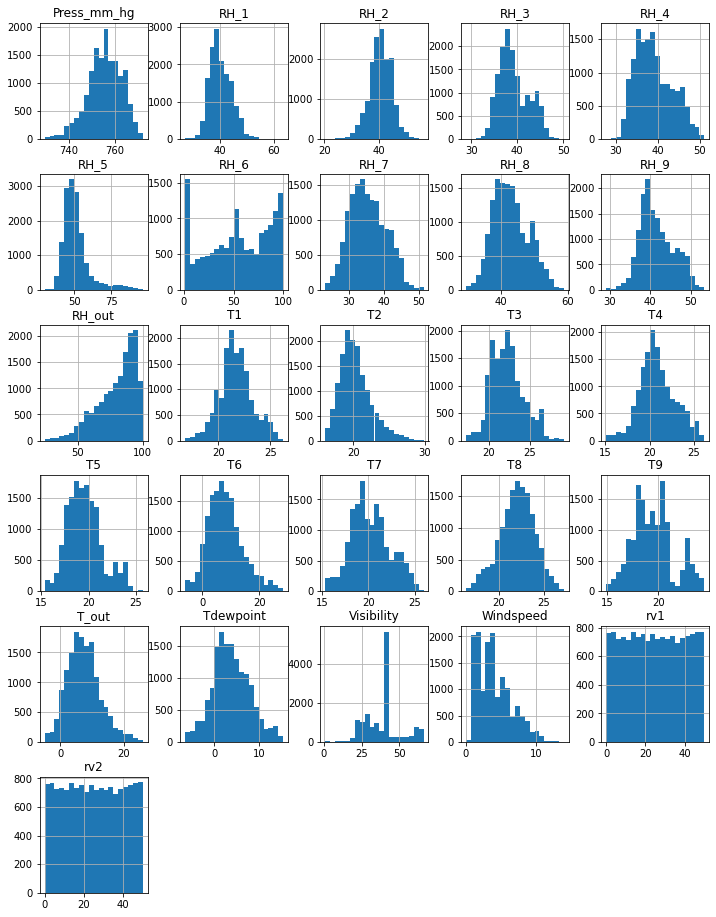

In [20]:
# Histograma de "features"
feature_vars.hist(bins = 20 , figsize= (12,16)) ;

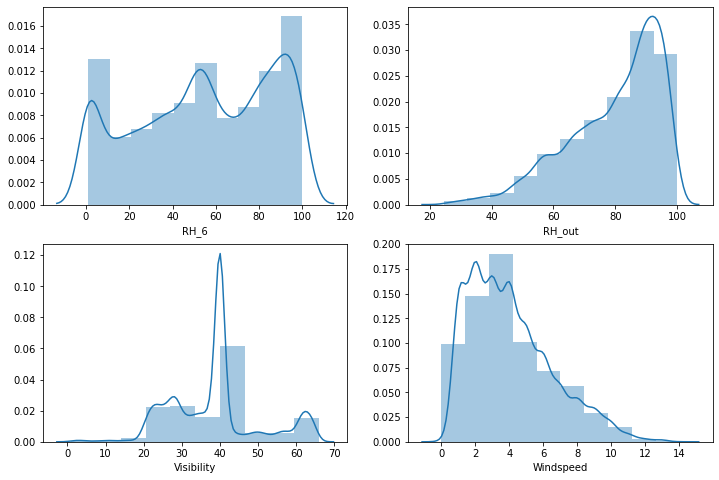

In [21]:
# RH_6 , RH_out , Visibility , Windspeed distribucines irregulares
f, ax = plt.subplots(2,2,figsize=(12,8))
vis1 = sns.distplot(feature_vars["RH_6"],bins=10, ax= ax[0][0])
vis2 = sns.distplot(feature_vars["RH_out"],bins=10, ax=ax[0][1])
vis3 = sns.distplot(feature_vars["Visibility"],bins=10, ax=ax[1][0])
vis4 = sns.distplot(feature_vars["Windspeed"],bins=10, ax=ax[1][1])

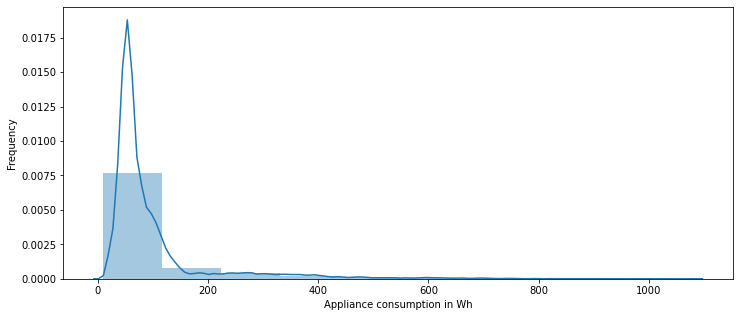

In [22]:
# Distribucion "Appliances"
f = plt.figure(figsize=(12,5))
plt.xlabel('Appliance consumption in Wh')
plt.ylabel('Frequency')
sns.distplot(target_vars , bins=10 ) ;

### Observaciones

1. Temperature - ¿Qué distribuciones vemos?
2. Humidity  - ¿Qué distribuciones vemos?
3. Appliance - ¿Es simétrica? Hay outliers
4. Visibilty - ¿Es simétrica? 
5. Windspeed - ¿Es simétrica? 


In [23]:
#Appliance con consumos bajos (menores a 200)
print('Percentage of the appliance consumption is less than 200 Wh')
print(((target_vars[target_vars <= 200].count()) / (len(target_vars)))*100 )

Percentage of the appliance consumption is less than 200 Wh
Appliances    90.250659
dtype: float64


### Correlation Plots

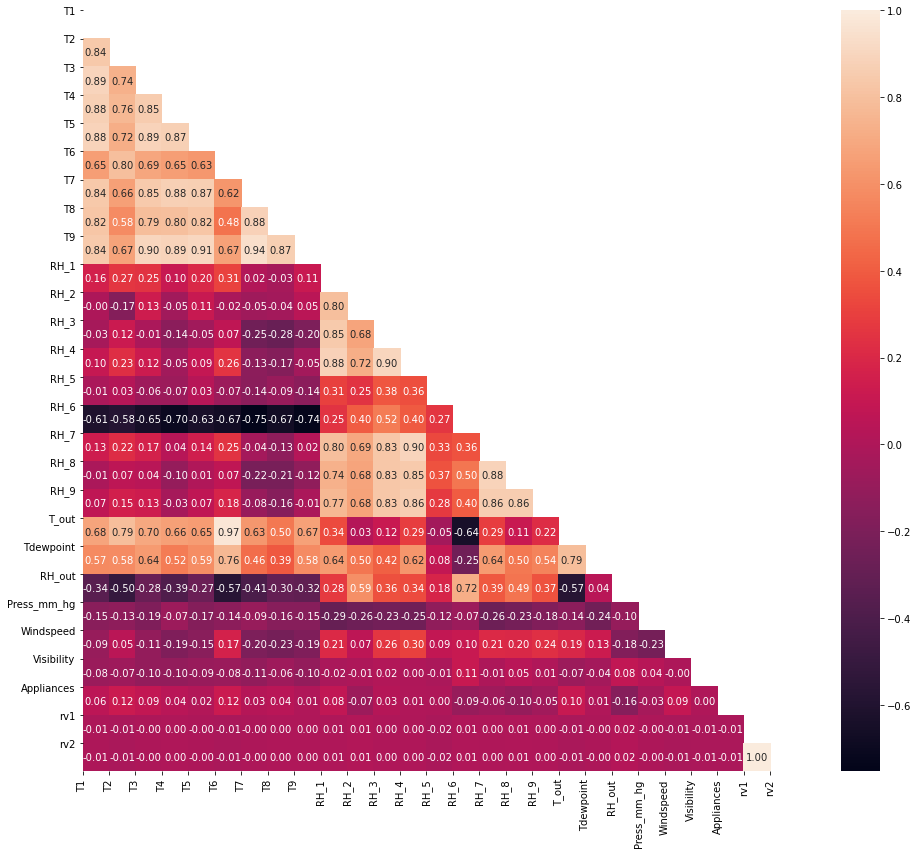

In [24]:
# Correlaciones
train_corr = train[col_temp + col_hum + col_weather +col_target+col_randoms]
corr = train_corr.corr()
# Quitar valores repetidos
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
  
f, ax = plt.subplots(figsize=(16, 14))
#Generar Heat Map,
sns.heatmap(corr, annot=True, fmt=".2f" , mask=mask,)
    # xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    # yticks
plt.yticks(range(len(corr.columns)), corr.columns)
    # plot
plt.show()

In [25]:
# Función para ver solo una mitad de la matriz
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Function to get top correlations 

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_corr, 40))

Top Absolute Correlations
rv1   rv2      1.000000
T6    T_out    0.974683
T7    T9       0.943921
T5    T9       0.910009
T3    T9       0.900209
RH_3  RH_4     0.899889
RH_4  RH_7     0.895120
T1    T3       0.892292
T4    T9       0.888264
T3    T5       0.887545
RH_7  RH_8     0.884849
T1    T5       0.884692
T7    T8       0.881513
RH_1  RH_4     0.880504
T1    T4       0.876682
T4    T7       0.876677
      T5       0.871733
T5    T7       0.869655
T8    T9       0.868251
RH_7  RH_9     0.860155
RH_4  RH_9     0.858454
RH_8  RH_9     0.857476
T3    T4       0.851790
RH_4  RH_8     0.848829
T3    T7       0.846021
RH_1  RH_3     0.845592
T1    T9       0.842862
      T7       0.837079
      T2       0.835729
RH_3  RH_9     0.834419
      RH_7     0.833924
      RH_8     0.831060
T1    T8       0.824657
T5    T8       0.824057
T2    T6       0.801219
RH_1  RH_7     0.800827
      RH_2     0.797598
T4    T8       0.796458
T3    T8       0.794213
T2    T_out    0.791553
dtype: float64

### Observaciones basadas en las correlaciones

1. Temperature

2. Weather attributes - (Visibility, Tdewpoint, Press_mm_hg)  

3. Humidity 

4. Variables aleatoras 


# Data Pre Processing

In [26]:
#Split training dataset 
train_X = train[feature_vars.columns]
train_y = train[target_vars.columns]

In [27]:
#Split testing dataset
test_X = test[feature_vars.columns]
test_y = test[target_vars.columns]

In [28]:
# Quitar columnas que se han visto que no muestran información (train)
train_X.drop(["rv1","rv2","Visibility","T6","T9"],axis=1 , inplace=True)

C:\Users\Ricard\anaconda3\envs\Smart_Energy\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
# Due to conlusion made above below columns are removed
test_X.drop(["rv1","rv2","Visibility","T6","T9"], axis=1, inplace=True)

In [30]:
train_X.columns

Index(['T1', 'T2', 'T3', 'T4', 'T5', 'T7', 'T8', 'RH_1', 'RH_2', 'RH_3',
       'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'T_out', 'Tdewpoint',
       'RH_out', 'Press_mm_hg', 'Windspeed'],
      dtype='object')

In [31]:
test_X.columns

Index(['T1', 'T2', 'T3', 'T4', 'T5', 'T7', 'T8', 'RH_1', 'RH_2', 'RH_3',
       'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'T_out', 'Tdewpoint',
       'RH_out', 'Press_mm_hg', 'Windspeed'],
      dtype='object')

In [32]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

# Create test and training set by including Appliances column

train = train[list(train_X.columns.values) + col_target ]

test = test[list(test_X.columns.values) + col_target ]

# Create dummy test and training set to hold scaled values

sc_train = pd.DataFrame(columns=train.columns , index=train.index)

sc_train[sc_train.columns] = sc.fit_transform(train)

sc_test= pd.DataFrame(columns=test.columns , index=test.index)

sc_test[sc_test.columns] = sc.fit_transform(test)


In [33]:
sc_train.head()

,T1,T2,T3,T4,T5,T7,T8,RH_1,RH_2,RH_3,...,RH_6,RH_7,RH_8,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed,Appliances
9544,0.569827,-0.383584,-0.384018,0.996241,-0.229230,0.349500,0.441571,-1.398755,-0.629413,-1.197521,...,0.103642,-1.657784,-0.848083,-1.033732,-0.978251,-0.803979,0.529878,1.167725,-1.112160,-0.270443
19366,1.254979,0.298556,1.561061,1.344290,0.163277,1.299615,1.112907,0.004687,0.604569,0.228904,...,-0.471944,-0.060622,0.086994,0.725258,-0.217827,0.365687,0.931169,0.226014,-1.248270,-0.464759
10816,0.320681,0.054501,0.366012,-0.229283,0.145189,0.297243,0.822507,1.388043,1.101918,-0.212353,...,-0.676999,0.311400,0.163327,-0.049050,1.120770,0.803317,-0.896934,-0.733721,0.929492,0.021032
15457,-0.246127,-0.961129,-0.489022,-0.159019,-0.162305,-0.363087,0.087967,-1.125096,-0.629413,-1.367589,...,-0.110291,-1.110463,0.001120,-1.368892,-1.339609,-1.006881,0.975757,-0.046587,-0.839939,-0.561918
2956,-0.246127,-0.024324,-0.300681,-1.013618,-0.061616,-0.579502,-0.564579,1.789743,1.680118,2.300361,...,1.453771,3.043131,2.777725,2.719419,0.630579,1.400086,0.864287,0.419763,1.065602,-0.464759


In [34]:
sc_test.head()

,T1,T2,T3,T4,T5,T7,T8,RH_1,RH_2,RH_3,...,RH_6,RH_7,RH_8,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed,Appliances
6314,-0.678526,-0.337714,-0.758967,-0.272083,-0.811540,-0.409392,-0.946375,-0.352449,-0.426736,0.306431,...,1.086122,-0.407472,-0.731388,-0.437093,-0.232839,-1.157146,-1.318014,0.377392,-0.809142,-0.367942
12257,0.814344,0.289201,1.432662,0.317741,1.062631,0.811654,1.049857,0.671740,1.084770,-0.220306,...,-1.056634,-0.276865,-0.989635,-0.554766,0.865496,0.485626,-0.967649,-0.401660,0.004891,3.087003
6271,-0.850621,-1.058130,-0.526796,-0.515812,-0.654758,-0.600348,-0.929458,-0.182731,0.160016,0.427270,...,0.869462,0.702690,0.538598,0.705174,-1.611203,-1.275901,1.191050,0.616061,-0.876978,-0.664080
18179,0.938750,0.485399,0.955147,1.146419,1.134714,1.502863,1.400044,-0.419664,-0.511502,-0.885589,...,-1.365905,-0.346975,-0.678579,-1.043214,0.591690,0.568755,-0.323430,0.701622,-1.216158,-0.565367
9661,0.005706,-0.368370,-0.396714,-0.137220,-0.595289,-0.270881,0.339334,-0.797748,-0.320955,-1.037265,...,0.039148,-1.025548,-1.028276,-1.198139,-0.307513,-0.001268,0.524227,0.917775,0.004891,0.224334


In [35]:
# sacar Appliances columna de training set

train_X =  sc_train.drop(['Appliances'] , axis=1)
train_y = sc_train['Appliances']

test_X =  sc_test.drop(['Appliances'] , axis=1)
test_y = sc_test['Appliances']

In [36]:
train_X.head()

,T1,T2,T3,T4,T5,T7,T8,RH_1,RH_2,RH_3,...,RH_5,RH_6,RH_7,RH_8,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed
9544,0.569827,-0.383584,-0.384018,0.996241,-0.229230,0.349500,0.441571,-1.398755,-0.629413,-1.197521,...,2.267242,0.103642,-1.657784,-0.848083,-1.033732,-0.978251,-0.803979,0.529878,1.167725,-1.112160
19366,1.254979,0.298556,1.561061,1.344290,0.163277,1.299615,1.112907,0.004687,0.604569,0.228904,...,-1.454588,-0.471944,-0.060622,0.086994,0.725258,-0.217827,0.365687,0.931169,0.226014,-1.248270
10816,0.320681,0.054501,0.366012,-0.229283,0.145189,0.297243,0.822507,1.388043,1.101918,-0.212353,...,-0.101804,-0.676999,0.311400,0.163327,-0.049050,1.120770,0.803317,-0.896934,-0.733721,0.929492
15457,-0.246127,-0.961129,-0.489022,-0.159019,-0.162305,-0.363087,0.087967,-1.125096,-0.629413,-1.367589,...,1.009651,-0.110291,-1.110463,0.001120,-1.368892,-1.339609,-1.006881,0.975757,-0.046587,-0.839939
2956,-0.246127,-0.024324,-0.300681,-1.013618,-0.061616,-0.579502,-0.564579,1.789743,1.680118,2.300361,...,0.137914,1.453771,3.043131,2.777725,2.719419,0.630579,1.400086,0.864287,0.419763,1.065602


In [37]:
train_y.head()

9544    -0.270443
19366   -0.464759
10816    0.021032
15457   -0.561918
2956    -0.464759
Name: Appliances, dtype: float64

# Implementacion del modelo

Probaremos los siguientes modelos:

**Linear regression models**

1.Ridge regression 

2.Lasso regression 

**Support Vector Machine**

3.Support vector regression 

**Nearest neighbour Regressor**

4.KNeighborsRegressor

**Ensmble models**

5.Random Forest Regressor

6.Gradient Boosting Regressor

7.ExtraTrees Regressor

**Neural Network**

8.Multi Layer Preceptron Regressor



In [38]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR


In [39]:
# Lista de modelos a probar
models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingClassifier: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()] ,
           ['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]


In [40]:
# Correr los modelos
import time
from math import sqrt
from sklearn.metrics import mean_squared_error

model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(train_X,train_y)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = metrics.r2_score(train_y,curr_model.predict(train_X))
    curr_model_data["Test_R2_Score"] = metrics.r2_score(test_y,curr_model.predict(test_X))
    curr_model_data["Test_RMSE_Score"] = sqrt(mean_squared_error(test_y,curr_model.predict(test_X)))
    model_data.append(curr_model_data)

[16:26:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [41]:
model_data

[{'Name': 'Lasso: ',
  'Train_Time': 0.009974241256713867,
  'Train_R2_Score': 0.0,
  'Test_R2_Score': 0.0,
  'Test_RMSE_Score': 1.0},
 {'Name': 'Ridge: ',
  'Train_Time': 0.006978034973144531,
  'Train_R2_Score': 0.1375528613228285,
  'Test_R2_Score': 0.12139099895516814,
  'Test_RMSE_Score': 0.937341453817568},
 {'Name': 'KNeighborsRegressor: ',
  'Train_Time': 0.07579421997070312,
  'Train_R2_Score': 0.6814639376039895,
  'Test_R2_Score': 0.4855598647200512,
  'Test_RMSE_Score': 0.7172448224141802},
 {'Name': 'SVR:',
  'Train_Time': 9.040967226028442,
  'Train_R2_Score': 0.23572363185689515,
  'Test_R2_Score': 0.20993387920257733,
  'Test_RMSE_Score': 0.8888566368078841},
 {'Name': 'RandomForest ',
  'Train_Time': 25.84773826599121,
  'Train_R2_Score': 0.9393208146439452,
  'Test_R2_Score': 0.5573445355040687,
  'Test_RMSE_Score': 0.6653235787915015},
 {'Name': 'ExtraTreeRegressor :',
  'Train_Time': 9.921844005584717,
  'Train_R2_Score': 1.0,
  'Test_R2_Score': 0.6290452743728374,


In [42]:
# Pasar a datframe
df = pd.DataFrame(model_data)

In [43]:
df

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,Lasso:,0.009974,0.000000,0.000000,1.000000
1,Ridge:,0.006978,0.137553,0.121391,0.937341
2,KNeighborsRegressor:,0.075794,0.681464,0.485560,0.717245
3,SVR:,9.040967,0.235724,0.209934,0.888857
4,RandomForest,25.847738,0.939321,0.557345,0.665324
5,ExtraTreeRegressor :,9.921844,1.000000,0.629045,0.609061
6,GradientBoostingClassifier:,6.229878,0.333526,0.231988,0.876363
7,XGBRegressor:,1.753424,0.322174,0.226322,0.879590
8,MLPRegressor:,3.200639,0.298567,0.243178,0.869955


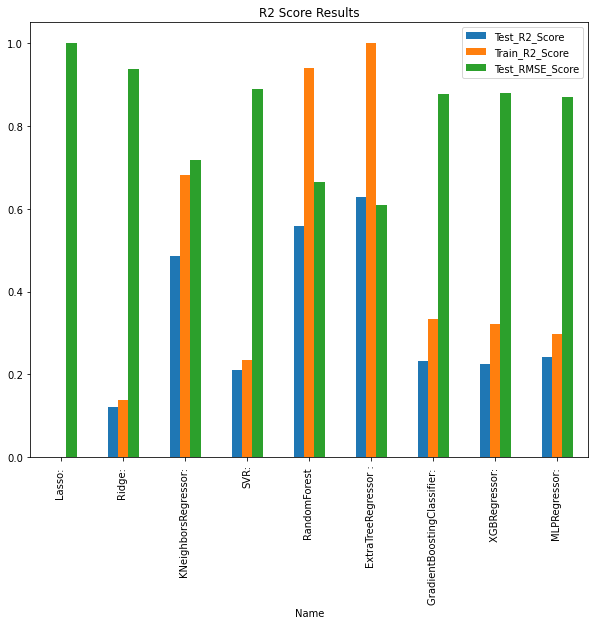

In [44]:
df.plot(x="Name", y=['Test_R2_Score' , 'Train_R2_Score' , 'Test_RMSE_Score'], kind="bar" , title = 'R2 Score Results' , figsize= (10,8)) ;

### Obervaciones
1. Mejor modelo Extra Tree Regressor con R2 score of 0.57
2. Menor RMSE score también Extra Tree Regressor 0.65
2. Lasso regularization la peor!


# Configurar parámetros 

In [45]:
from sklearn.model_selection import GridSearchCV
param_grid = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': ["auto", "sqrt", "log2"]
            }]
reg = ExtraTreesRegressor(random_state=40)
# Inizializar
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1 , scoring='r2' , verbose=2)
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 12.3min finished


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=40), n_jobs=-1,
             param_grid=[{'max_depth': [80, 150, 200, 250],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [100, 150, 200, 250]}],
             scoring='r2', verbose=2)

In [46]:
# Tuned parameter set
grid_search.best_params_

{'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 250}

In [47]:
# Mejores parámetros para ExtraTreesRegressor
grid_search.best_estimator_

ExtraTreesRegressor(max_depth=80, max_features='sqrt', n_estimators=250,
                    random_state=40)

In [48]:
# R2 score en training
grid_search.best_estimator_.score(train_X,train_y)

1.0

In [49]:
# R2 score en test
grid_search.best_estimator_.score(test_X,test_y)

0.6377804349254067

In [50]:
# RMSE score en test
np.sqrt(mean_squared_error(test_y, grid_search.best_estimator_.predict(test_X)))

0.6018467953512698

### Observaciones


1. Mejor combinación - 'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 200

    
2. Training set  R2 score de 1.0 (overfitting?)


3. Test set R2 score de 0.63 mejora el de 0.57 


4. Test set RMSE score de 0.60 mejora el de 0.65 




### Features 

In [51]:
# Mejores features
feature_indices = np.argsort(grid_search.best_estimator_.feature_importances_)

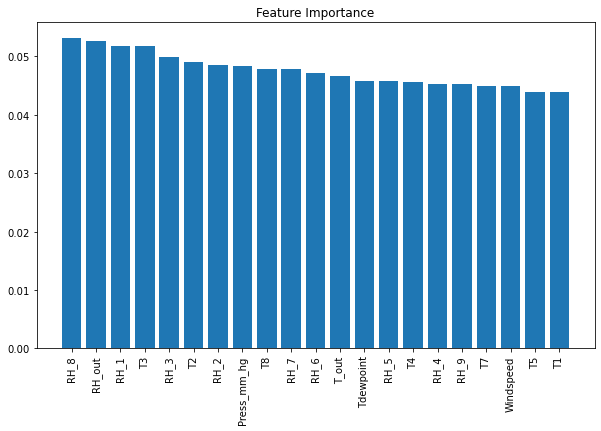

In [52]:
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
names = [train_X.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(10,6))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(train_X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(train_X.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [53]:
# top 5
names[0:5]

['RH_8', 'RH_out', 'RH_1', 'T3', 'RH_3']

In [54]:
# ultimas 5
names[-5:]

['RH_9', 'T7', 'Windspeed', 'T5', 'T1']

In [55]:
# Reducimos set a las 5 mejores
train_important_feature = train_X[names[0:5]]
test_important_feature = test_X[names[0:5]]

In [56]:
# Volvemos a probar!

from sklearn.base import clone
cloned_model = clone(grid_search.best_estimator_)
cloned_model.fit(train_important_feature , train_y)

ExtraTreesRegressor(max_depth=80, max_features='sqrt', n_estimators=250,
                    random_state=40)

In [57]:
# Nuevos scores

print('Training set R2 Score - ', metrics.r2_score(train_y,cloned_model.predict(train_important_feature)))
print('Testing set R2 Score - ', metrics.r2_score(test_y,cloned_model.predict(test_important_feature)))
print('Testing set RMSE Score - ', np.sqrt(mean_squared_error(test_y, cloned_model.predict(test_important_feature))))


Training set R2 Score -  0.9999837366892088
Testing set R2 Score -  0.47520832858877793
Testing set RMSE Score -  0.7244250626608815


### Observaciones

1. Features

    a. top 5 - 'RH_out', 'RH_8', 'RH_1', 'T3', 'RH_3'
    
    b. peores 5 - 'T7','Tdewpoint','Windspeed','T1','T5'
    

3. R2 baja mucho así que mejor no usar el dataset reducido